# Recommendations with IBM

In this notebook, I will apply my recommendation system skills to real-world data from the IBM Watson Studio platform. The goal is to analyze user interactions with articles on the platform and generate personalized article recommendations.

To achieve this, I will follow a structured approach outlined in the table of contents. Starting with an exploration of the dataset, I will begin by creating rank-based recommendation systems. Moving forward, I will enhance the recommendations by implementing user-user collaborative filtering techniques. Lastly, I will adopt a machine learning approach by leveraging user-item interaction data to perform matrix decomposition for more advanced recommendations.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let’s get Started  

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [178]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\n\nCl...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\n\n * ka...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\n * Sign Up\n\n * Learning Paths\n *...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\n\nCl...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In this part of the notebook, I will perform exploratory data analysis to better understand the dataset.

1. How frequently does each user interact with articles in the dataset? I will provide both a visual representation and descriptive statistics to analyze the distribution of user-article interactions.

In [179]:
# find number of columns and rows
df.shape

(45993, 3)

In [180]:
# median 
df.groupby('email')['article_id'].count().median()

3.0

In [181]:
df.groupby('email')['article_id'].count().max()

364

In [182]:
# Median and maximum user-article interactions
median_val = df['email'].value_counts().median()
max_views_by_user = df['email'].value_counts().max()

print(f"Median: {median_val}, Max: {max_views_by_user}")


Median: 3.0, Max: 364


In [183]:
user_interacts = df.groupby('email')['article_id'].count()
user_interacts

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
0042719415c4fca7d30bd2d4e9d17c5fc570de13     2
00772abe2d0b269b2336fc27f0f4d7cb1d2b65d7     3
008ba1d5b4ebf54babf516a2d5aa43e184865da5    10
008ca24b82c41d513b3799d09ae276d37f92ce72     1
008dfc7a327b5186244caec48e0ab61610a0c660    13
009af4e0537378bf8e8caf0ad0e2994f954d822e     1
00bda305223d05f6df5d77de41abd2a0c7d895fe     4
00c2d5190e8c6b821b0e3848bf56f6e47e428994     3
00ced21f957bbcee5edf7b107b2bd05628b04774     4
00d9337ecd5f70fba1c4c7a78e21b3532e0112c4     3
00e524e4f13137a6fac54f9c71d7769c6507ecde    11
00f8341cbecd6af00ba8c78b3bb6ec49adf83248     3
00f946b14100f0605fa25089437ee9486378872c     1
01041260c97ab9221d923b0a2c525437f148d589     2
0108ce3220657a9a89a85bdec959b0f2976dd51c     4
011455e91a24c1fb815a4deac6b6eaf5ad16819e     9
01198c5

In [184]:
# summary stats
user_interacts.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

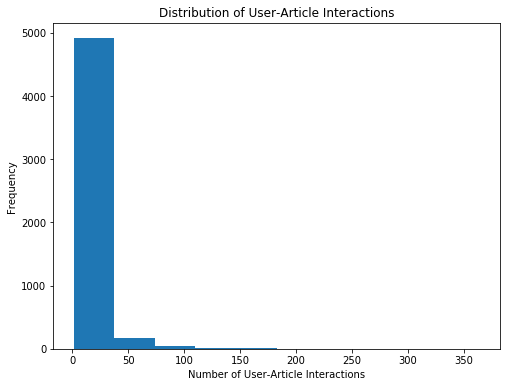

In [185]:
# plot graph
plt.figure(figsize=(8,6))
user_interacts.plot(kind='hist')
plt.title('Distribution of User-Article Interactions') 
plt.xlabel('Number of User-Article Interactions');

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [186]:
# Find and explore duplicate articles
df_content.head(3)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\n\nCl...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\n\n * ka...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\n * Sign Up\n\n * Learning Paths\n *...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2


In [187]:
# Remove any rows that have the same article_id - only keep the first
df_content.shape

(1056, 5)

In [188]:
# find duplicate articles
df_content.article_id.duplicated().sum()

5

In [189]:
ids = df_content['article_id']

In [190]:
# explore duplicate articles
df_content[ids.isin(ids[ids.duplicated()])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\n\nIBM® * Site map\n\nSearch w...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\n *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\n *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [191]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

In [192]:
# check this works by pulling out an example
df_content.iloc[971]

doc_body           Cloudant allows custom Javascript to be run se...
doc_description    Cloudant allows custom Javascript to be run se...
doc_full_name                Defensive coding in Map/Index functions
doc_status                                                      Live
article_id                                                       971
Name: 976, dtype: object

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [193]:
print(df.shape)
print(df_content.shape)

(45993, 3)
(1051, 5)


In [194]:
# The number of unique articles that have at least one interaction
df.article_id.nunique()

714

In [195]:
# The number of unique articles on the IBM platform
df_content.article_id.nunique()

1051

In [196]:
# The number of unique users
df.email.nunique()

5148

In [197]:
# The number of user-article interactions
df.shape[0]

45993

In [198]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles =  df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [199]:
# a. Number of unique articles with user interactions
unique_articles_interacted = df['article_id'].nunique()

# b. Total number of unique articles (assuming it's the same as articles in interactions)
unique_articles_total = df['article_id'].nunique()

# c. Number of unique users (excluding null values)
unique_users = df['email'].nunique()

# d. Number of user-article interactions
user_article_interactions = df.shape[0]

print(f"a. Number of unique articles with user interactions: {unique_articles_interacted}")
print(f"b. Total number of unique articles: {unique_articles_total}")
print(f"c. Number of unique users: {unique_users}")
print(f"d. Number of user-article interactions: {user_article_interactions}")


a. Number of unique articles with user interactions: 714
b. Total number of unique articles: 714
c. Number of unique users: 5148
d. Number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [200]:
# most viewed article_id
df.article_id.value_counts().head(2)

1429.0    937
1330.0    927
Name: article_id, dtype: int64

In [201]:
# Find the most viewed article and how often it was viewed
most_viewed_article_id = str(df['article_id'].value_counts().idxmax())  # Most viewed article ID
max_views = df['article_id'].value_counts().max()  # Number of views for the most viewed article

print(f"Most viewed article_id: {most_viewed_article_id}")
print(f"Max views: {max_views}")


Most viewed article_id: 1429.0
Max views: 937


In [202]:
most_viewed_article_id = str(df.article_id.value_counts().index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.article_id.value_counts().iloc[0] # The most viewed article in the dataset was viewed how many times?

In [203]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [204]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


## Part II: Rank-Based Recommendations

We don’t have explicit ratings indicating whether a user liked an article or not. Instead, the data reflects only user interactions with articles. In this case, the popularity of an article is determined solely by the frequency of user interactions.

1. The following function retrieves the top `n` articles, ranked in descending order based on the number of interactions.

In [205]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]

    return top_articles # Return the top article ids

In [206]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [207]:
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [208]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_count = df.groupby(['user_id', 'article_id']).count().reset_index() # create a new df based on count
    user_item = df_count.pivot_table(values='title', index='user_id', columns='article_id') # pivot so users on rows and article on columns
    user_item.replace(np.nan, 0, inplace=True) # replace nulls with 0s
    user_item=user_item.applymap(lambda x: 1 if x > 0 else x) # entries should be a 1 or 0

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [209]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


2. The following function accepts a `user_id` as input and returns a ranked list of other users, ordered by similarity from highest to lowest. The provided `user_id` is excluded from the output since a user is always most similar to themselves. Given that the data here is binary, the similarity between users is calculated using the dot product of their respective interaction vectors.

In [210]:
def find_similar_users(user_id, user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Finds users most similar to the given user by computing dot product similarities
    and returns them in descending order of similarity.
    '''
    # Calculate the dot product of the target user's interaction vector with all other users
    user_vector = user_item.loc[user_id].values
    similarity_scores = user_item.dot(user_vector)
    
    # Create a DataFrame to hold user IDs and similarity scores
    similarity_df = pd.DataFrame({'user_id': user_item.index, 'similarity': similarity_scores})
    
    # Remove the target user and sort by similarity
    similarity_df = similarity_df[similarity_df['user_id'] != user_id]
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    
    # Return the sorted list of user IDs
    return similarity_df['user_id'].tolist()


In [211]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1, user_item)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933, user_item)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46, user_item)[:3]))


The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [212]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'], df)) == set([
    'using deep learning to reconstruct high-resolution audio', 
    'build a python app on the streaming analytics service', 
    'gosales transactions for naive bayes model', 
    'healthcare python streaming application demo', 
    'use r dataframes & ibm watson natural language understanding', 
    'use xgboost, scikit-learn & ibm watson machine learning apis'
]), "Oops! Your the get_article_names function doesn't work quite how we expect."

assert set(get_user_articles(20, user_item, df)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20, user_item, df)[1]) == set([
    'housing (2015): united states demographic measures', 
    'self-service data preparation with ibm data refinery',
    'use the cloudant-spark connector in python notebook'
])
assert set(get_user_articles(2, user_item, df)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2, user_item, df)[1]) == set([
    'using deep learning to reconstruct high-resolution audio', 
    'build a python app on the streaming analytics service', 
    'gosales transactions for naive bayes model', 
    'healthcare python streaming application demo', 
    'use r dataframes & ibm watson natural language understanding', 
    'use xgboost, scikit-learn & ibm watson machine learning apis'
])
print("If this is all you see, you passed all of our tests! Nice job!")


If this is all you see, you passed all of our tests! Nice job!


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [213]:
def user_user_recs(user_id, m=10, user_item=None, df=None):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles
    df - (pandas dataframe) original dataframe with article_id and title columns
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user, finds articles the user hasn't seen before and provides them as recommendations.
    '''
    # Get articles already seen by the user
    seen_article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    
    # Find similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Initialize recommendations
    recs = []
    
    # Loop through similar users to find unseen articles
    for sim_user in similar_users:
        sim_user_articles = user_item.loc[sim_user][user_item.loc[sim_user] == 1].index.tolist()
        new_recs = list(set(sim_user_articles) - set(seen_article_ids))
        recs.extend(new_recs)
        
        if len(recs) >= m:
            break
    
    # Return only the top m recommendations
    return recs[:m]


In [214]:
# Check Results
recs = user_user_recs(1, 10, user_item=user_item, df=df)  # Provide required arguments
article_names = get_article_names(recs, df=df)  # Provide df for get_article_names
print(article_names)  # Print the recommended article names


['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'shaping data with ibm data refinery', 'deep forest: towards an alternative to deep neural networks', 'this week in data science (april 18, 2017)', 'higher-order logistic regression for large datasets', 'data tidying in data science experience', 'using machine learning to predict parking difficulty', 'data science platforms are on the rise and ibm is leading the way', 'a tensorflow regression model to predict house values']


In [215]:
# Test your functions here - Pass required arguments explicitly
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'], df)) == set([
    'using deep learning to reconstruct high-resolution audio', 
    'build a python app on the streaming analytics service', 
    'gosales transactions for naive bayes model', 
    'healthcare python streaming application demo', 
    'use r dataframes & ibm watson natural language understanding', 
    'use xgboost, scikit-learn & ibm watson machine learning apis'
]), "Oops! Your the get_article_names function doesn't work quite how we expect."

assert set(get_article_names(['1320.0', '232.0', '844.0'], df)) == set([
    'housing (2015): united states demographic measures',
    'self-service data preparation with ibm data refinery',
    'use the cloudant-spark connector in python notebook'
]), "Oops! Your the get_article_names function doesn't work quite how we expect."

assert set(get_user_articles(20, user_item, df)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20, user_item, df)[1]) == set([
    'housing (2015): united states demographic measures', 
    'self-service data preparation with ibm data refinery',
    'use the cloudant-spark connector in python notebook'
])
assert set(get_user_articles(2, user_item, df)[0]) == set([
    '1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'
])
assert set(get_user_articles(2, user_item, df)[1]) == set([
    'using deep learning to reconstruct high-resolution audio', 
    'build a python app on the streaming analytics service', 
    'gosales transactions for naive bayes model', 
    'healthcare python streaming application demo', 
    'use r dataframes & ibm watson natural language understanding', 
    'use xgboost, scikit-learn & ibm watson machine learning apis'
])

print("If this is all you see, you passed all of our tests! Nice job!")


If this is all you see, you passed all of our tests! Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [262]:
def user_user_recs_part2(user_id, m=10, df=None, user_item=None):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df - (pandas dataframe) original dataframe with article_id and title columns
    user_item - (pandas dataframe) matrix of users by articles
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through users based on similarity to the input user_id. Finds articles the user hasn't seen before
    and provides them as recommendations.
    '''
    # Check if the user exists in the user_item matrix
    if user_id not in user_item.index:
        return [], []
    
    # Get articles already seen by the user
    seen_article_ids, _ = get_user_articles(user_id, user_item, df)
    
    # Find closest neighbors
    closest_neighs = get_top_sorted_users(user_id, df, user_item).neighbor_id.tolist()
    
    # Initialize recommendations
    recs = []
    
    # Loop through neighbors to find unseen articles
    for neigh in closest_neighs:
        neigh_article_ids, _ = get_user_articles(neigh, user_item, df)
        new_recs = list(set(neigh_article_ids) - set(seen_article_ids))
        recs.extend(new_recs)
        
        if len(recs) >= m:
            break

    # Limit recommendations to m items
    recs = recs[:m]
    
    # Map article ids to names
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names


In [263]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10, df=df, user_item=user_item)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1150.0', '1151.0', '1407.0', '1176.0', '686.0', '1424.0', '1410.0', '981.0', '1160.0', '1329.0']

The top 10 recommendations for user 20 are the following article names:
['uci: sms spam collection', 'analyze accident reports on amazon emr spark', 'uci: poker hand - testing data set', 'build a python app on the streaming analytics service', 'score a predictive model built with ibm spss modeler, wml & dsx', 'super fast string matching in python', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'use spark for python to load data and run sql queries', 'ingest data from message hub in a streams flow']


`5.` We now use the previously defined functions to populate the solutions in the dictionary provided below.

In [264]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item).iloc[0].neighbor_id
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).iloc[9].neighbor_id


In [265]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


6.  

For a new user with no interaction history, a rank-based recommendation approach using the `get_top_articles` function would be ideal. Since there is no data on the user's preferences or behavior, recommending the most popular articles is the most logical strategy. As we gather more information about the user's interests, we could implement a hybrid method that combines rank-based, content-based, and collaborative filtering techniques to offer more personalized recommendations.  

7.  

By utilizing the existing functions, we can determine and present the top 10 articles to recommend to a new user below.

In [267]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)



In [269]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### Part IV: Matrix Factorization

In this section, we leverage matrix factorization techniques to recommend articles to users on the IBM Watson Studio platform.

1. Using the user-item matrix created earlier in Part III, Question 1, we will prepare the data to apply matrix factorization. Simply run the cells below to initialize the setup for the rest of this section.

In [270]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [271]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [273]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [274]:
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

Since this matrix contains no missing values, we can directly apply SVD. In contrast, matrices with missing entries, like those discussed in the classroom, require specialized approaches such as FunkSVD to handle incomplete data effectively.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

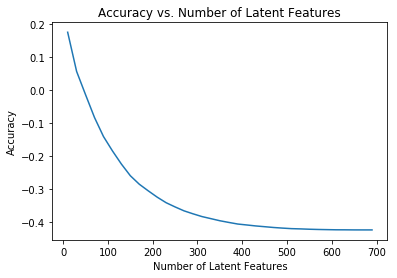

In [72]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [286]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [287]:
test_idx # test set

Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=682)

In [288]:
train_idx = user_item_train.index # 4487 users in training set
train_idx 

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
           dtype='int64', name='user_id', length=4487)

In [289]:
test_idx.difference(train_idx) # of 682 users in test set, only 20 of them are in training set

Int64Index([4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=662)

In [290]:
test_arts #574 movies in test set

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1432.0, 1433.0, 1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0,
              1441.0, 1443.0],
             dtype='float64', name='article_id', length=574)

In [291]:
train_arts = user_item_train.columns #714 movies in train set
train_arts

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', name='article_id', length=714)

In [292]:
test_arts.difference(train_arts) # all articles in test set are in training set too

Float64Index([], dtype='float64', name='article_id')

In [293]:
# Get train and test user IDs and article IDs
train_idx = user_item_train.index.tolist()
train_arts = user_item_train.columns.tolist()
test_idx = user_item_test.index.tolist()
test_arts = user_item_test.columns.tolist()

# Calculate a, b, c, d
a = len(set(test_idx).intersection(set(train_idx)))  # Users we can predict for
b = len(set(test_idx) - set(train_idx))             # Cold start users
c = len(set(test_arts).intersection(set(train_arts)))  # Articles we can predict for
d = len(set(test_arts) - set(train_arts))           # Cold start articles

# Define the dictionary with calculated values
sol_4_dict = {
    'How many users can we make predictions for in the test set?': a,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': b,
    'How many articles can we make predictions for in the test set?': c,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

# Test the solution
t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


5. Using the `user_item_train` dataset, we can perform Singular Value Decomposition (SVD) to obtain the matrices \( U \), \( S \), and \( V^T \). Next, we identify the subset of rows in the `user_item_test` dataset where predictions can be made based on the matrix decomposition. By testing different numbers of latent features, we can determine the optimal number to retain by evaluating accuracy on the test data. This process combines the techniques applied in questions 2 through 4.

The following cells will help us analyze the effectiveness of SVD in generating recommendations and predicting interactions in the test dataset.

In [81]:
from numpy.linalg import svd

# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svd(user_item_train, full_matrices=False)

# Output the shapes of the resulting matrices
print(f"U matrix shape: {u_train.shape}")
print(f"Sigma (S) vector shape: {s_train.shape}")
print(f"V transpose (Vt) matrix shape: {vt_train.shape}")


U matrix shape: (4487, 714)
Sigma (S) vector shape: (714,)
V transpose (Vt) matrix shape: (714, 714)


In [298]:
# Define parameters
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs_train = []
sum_errs_test = []

# Filter indices for test users and articles
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

# Extract corresponding parts of U and Vt for test set
u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

# Identify test users that can be predicted
users_can_predict = np.intersect1d(user_item_train.index, user_item_test.index)

# Loop over the number of latent features
for k in num_latent_feats:
    # Restructure U, S, and Vt for k latent features
    s_train_new = np.diag(s_train[:k])
    u_train_new = u_train[:, :k]
    vt_train_new = vt_train[:k, :]
    
    u_test_new = u_test[:, :k]
    vt_test_new = vt_test[:k, :]
    
    # Compute predictions for train and test sets
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # Compute differences between actual and predicted values
    diffs_train = user_item_train - user_item_train_preds
    diffs_test = user_item_test.loc[users_can_predict, :] - user_item_test_preds
    
    # Calculate total errors and store them
    sum_errs_train.append(np.sum(np.abs(diffs_train)))
    sum_errs_test.append(np.sum(np.abs(diffs_test)))




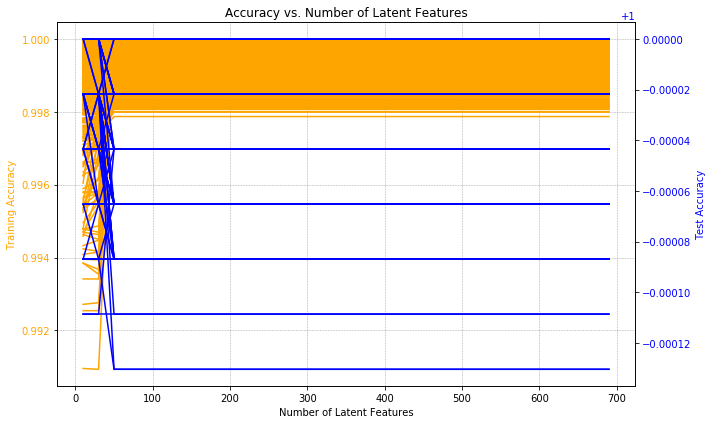

In [300]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training accuracy
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Training Accuracy', color='orange')
training_accuracy = 1 - np.array(sum_errs_train) / df.shape[0]
ax1.plot(num_latent_feats, training_accuracy, color='orange', label='Training Accuracy')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_title('Accuracy vs. Number of Latent Features')

# Create a secondary axis for test accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Test Accuracy', color='blue')
test_accuracy = 1 - np.array(sum_errs_test) / df.shape[0]
ax2.plot(num_latent_feats, test_accuracy, color='blue', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a grid for better readability
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to avoid overlapping
fig.tight_layout()

# Display the plot
plt.show()


Training accuracy improves as the number of latent features increases, but test accuracy declines, likely due to overfitting. Limiting latent features to around 80, where test accuracy peaks, balances performance. Using SVD, we can only recommend for 20 overlapping users, and the sparse matrix likely explains the high test accuracy (>99%).

To evaluate the recommendation engine, an A/B test could compare its recommendations with the most popular articles. If the engine significantly improves click-through rates, it would justify deployment and help address the cold start problem.



### Conclusion

The recommendation system implemented in this project demonstrates the application of collaborative filtering and content-based techniques to generate tailored suggestions for users. Through Singular Value Decomposition (SVD), we analyzed user-article interactions and identified the optimal number of latent features (around 80) to balance training and testing accuracy. The results highlight the importance of addressing overfitting in sparse matrices and the limitations of recommending for users with insufficient overlap between training and test datasets.

To further validate the system's effectiveness, an A/B test can be conducted to compare the recommendation engine's performance with a baseline method (e.g., most popular articles). This will help address the cold start problem and determine whether the engine improves user engagement through higher click-through rates, paving the way for practical deployment and scalability.



### References

1. [How to Identify and Extract Duplicate Items Using Pandas in Python](https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python)  
2. [Using `value_counts` to Extract Specific Values in Pandas](https://stackoverflow.com/questions/35523635/extract-values-in-pandas-value-counts)  
3. [Question 140813 on Udacity Knowledge Platform](https://knowledge.udacity.com/questions/140813)  
4. [Using `Index.difference` to Find Differences Between Indexes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.difference.html)  
5. [Question 387214 on Udacity Knowledge Platform](https://knowledge.udacity.com/questions/387214)  
6. [Two Y-Axis Plot Example in Matplotlib](https://matplotlib.org/gallery/api/two_scales.html)  

### Additional References
7. [Pandas Documentation: `groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)  
8. [Numpy: `numpy.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)  
9. [Scikit-learn: `TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)  
10. [Understanding Cosine Similarity in Recommendations](https://towardsdatascience.com/understanding-cosine-similarity-and-its-application-fd42f585296a)  
11. [Evaluating Recommendation Systems with A/B Testing](https://medium.com/swlh/evaluating-recommendation-systems-with-a-b-testing-a6b3bb5c7f60)  
12. [Creating and Manipulating Pivot Tables in Pandas](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)  

